In [4]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [79]:
import json
with open("/home/a/eg_dataset.json", 'rb') as handle:
    dataset = json.load(handle)
    

dataset_sz = len(dataset)

print("Size dataset: {}".format(dataset_sz))

Size dataset: 2927


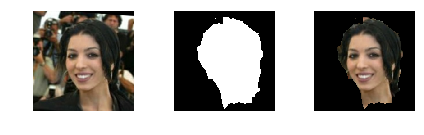

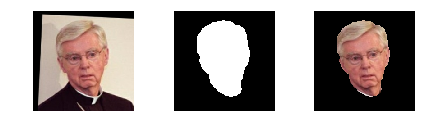

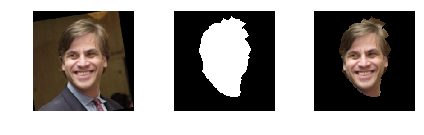

In [80]:


def read_mask_mat(mat_fname, mask_sz):
    """
    extract mask as a binary image array
        :mat_fname: str
        :mask_sz: tuple
    """
    h = tf.io.read_file(mat_fname)
    mat = tf.image.decode_jpeg(h, channels=3)
    #mask = mat["mask"]
    #mask = mask.astype( np.float32 )
    mask = mat
    mask_rsz = tf.image.resize(mask, mask_sz)
    #print(mask_rsz.shape)
    m = mask_rsz[:,:,2] < 1
    #m = m.astype("uint8")
    #m = m *255
    mask_rsz = m
    #mask_rsz[:,:,1] = m
    mask_rsz = np.expand_dims(mask_rsz, axis=2)
    return mask_rsz


def read_image_file(img_fname, crop, img_input_sz):
    """
    read raw image, resize and output array
    """
    #bgr = cv2.imread( img_fname )
    h = tf.io.read_file(img_fname)
    bgr = tf.image.decode_jpeg(h, channels=3)
    #rgb = bgr[:, :, ::-1]
    rgb = bgr
    if np.sum(crop) != 0: #image must be cropped
        assert len(crop)==4, "crop specs list must be of length 4"
        yi, yf, xi, xf = crop
        rgb = rgb[yi:yf, xi:xf, :]
    
    rgb_rsz = tf.image.resize(rgb, (600, 800))
    img_rsz = tf.image.resize(rgb_rsz, img_input_sz)
    return img_rsz


examples_id = np.random.choice(range(dataset_sz), 3)

mask_sz, img_input_sz = (224, 224), (224, 224) # The model takes images of that size

for idx in examples_id:
    example = dataset[idx]
    mask = read_mask_mat(example["mask"], mask_sz)
    img = read_image_file(example["img"], example["crop"], img_input_sz)
    combo = mask * img
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img/255.0)
    ax[1].imshow(mask[:,:,0]/255.0, cmap="gray")
    ax[2].imshow(combo/255.0)
    ax[0].axis("off"), ax[1].axis("off"), ax[2].axis("off")
    plt.tight_layout()
    plt.show()

In [81]:
split_ratio = 0.8 

indexes = [i for i in range(dataset_sz)]
random.shuffle(indexes)
split_idx = int( dataset_sz * split_ratio )
train_indexes = indexes[0:split_idx]
train_sz = len(train_indexes)
valid_indexes = indexes[split_idx::]
valid_sz = len(valid_indexes)

print("Training set size {} | Validation set size {}".format(train_sz, valid_sz))

Training set size 2341 | Validation set size 586


In [96]:
def read_img(img_path, crop_specs, input_sz=(256, 256)):
    """
    Read image file and return cropped, resized, intensity-normalized array
        Arguments
            :img_path: str
            :crop_specs: list
            :input_sz: tuple
        Output
            :rgb_norm: numpy array
    """
    h = tf.io.read_file(img_path)
    rgb = tf.image.decode_jpeg(h, channels=3)
    #rgb = bgr[:,:,::-1]
    if len(crop_specs) == 4:
        rgb = rgb[ crop_specs[0]:crop_specs[1], crop_specs[2]:crop_specs[3], :]
    rgb = tf.image.resize(rgb, (600, 800))
    rgb = tf.image.resize(rgb, input_sz)
    rgb_norm = rgb/ 255.
    
    return rgb_norm



def read_mask(mask_path, input_sz=(256, 256)):
    """
    Read mat file with binary mask and returns an array of rank 3
        Arguments
            :mask_path: str
            :input_sz: tuple
        Output
            :mask: numpy array
    """
    h = tf.io.read_file(mask_path)
    mat = tf.image.decode_jpeg(h, channels=3)
    mask = mat
    mask_rsz = tf.image.resize(mask, input_sz)
    m = mask_rsz[:,:,2] < 1
    #m = m.astype("float32")
    mask_rsz = m
    mask_rsz = np.expand_dims(mask_rsz, axis=2)  
    return mask_rsz


from random import shuffle
def batch_gen(batch_sz, indexes, dataset, is_training):
    """
    """
    idx = 0 # pointer for indexes
    
    while 1:
        if is_training: shuffle(indexes)
        x_batch = np.zeros( (batch_sz, 256, 256, 3), dtype=np.float32)
        y_batch = np.zeros( (batch_sz, 256, 256, 1), dtype=np.float32)
        
        for row in range(batch_sz):
            example = dataset[indexes[idx]]
            crop_specs = example["crop"]
            img_path = example["img"]
            mask_path = example["mask"]
            rgb_norm = read_img(img_path, crop_specs)
            mask = read_mask(mask_path)
            x_batch[row] = rgb_norm[:,:,:]
            y_batch[row] = mask[:, :, :]
            idx += 1
            if (idx > len(indexes)-1):
                shuffle(indexes)
                idx = 0

        yield x_batch, y_batch

In [97]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Flatten, Dense, Activation
def relu6(x):
    return keras.backend.relu(x, max_value=6)


OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = Generator()
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_75 (Sequential)      (None, 128, 128, 64) 3072        input_5[0][0]                    
__________________________________________________________________________________________________
sequential_76 (Sequential)      (None, 64, 64, 128)  131584      sequential_75[0][0]              
__________________________________________________________________________________________________
sequential_77 (Sequential)      (None, 32, 32, 256)  525312      sequential_76[0][0]              
____________________________________________________________________________________________

In [ ]:
batch_sz = 5
n_epochs = 40
steps_per_epoch = len(train_indexes) // batch_sz
validation_steps = len(valid_indexes) // batch_sz

history = model.fit( x=batch_gen(batch_sz, train_indexes, dataset, is_training=1),\
        validation_data=batch_gen(batch_sz, valid_indexes, dataset, is_training=0),\
        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=n_epochs,\
        verbose=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 468 steps, validate for 117 steps
Epoch 1/40
468/468 [==============================] - 186s 397ms/step - loss: 0.3909 - accuracy: 0.9104 - val_loss: 0.3650 - val_accuracy: 0.9233
Epoch 2/40
358/468 [=====================>........] - ETA: 38s - loss: 0.3548 - accuracy: 0.9285

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
